In [1]:
#Copyright 2019 The TensorFlow Authors.

#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 7_Tensorflow Hub and Transfer Learning

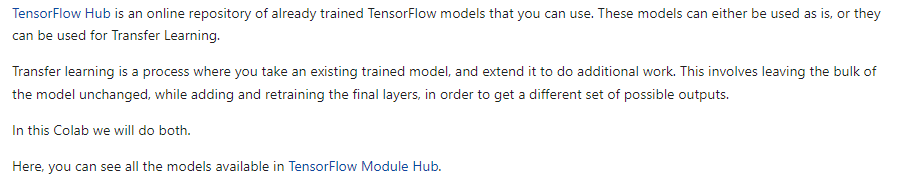

[Tensorflow Hub](https://www.kaggle.com/models?tfhub-redirect=true)

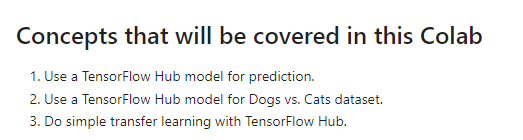

#### Install TensorFlow Hub

In [2]:
!pip install --upgrade tensorflow_hub

#### Import Packages

In [3]:
import tensorflow as tf
     
import matplotlib.pylab as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers
     
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

import numpy as np
import PIL.Image as Image

#### Part 1: Use a TensorFlow Hub MobileNet for prediction

##### Download the classifier
Download the MobileNet model and create a Keras model from it. MobileNet is expecting images of 224 
 224 pixels, in 3 color channels (RGB).

In [4]:
CLASSIFIER_URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
IMAGE_RES = 224

model = tf.keras.Sequential()

# Wrap the KerasLayer in a Lambda layer
model.add(tf.keras.layers.Lambda(
    lambda x: hub.KerasLayer(CLASSIFIER_URL)(x),
    input_shape=(IMAGE_RES, IMAGE_RES, 3)
))

# Build the model (optional, but recommended)
model.build()

# Print a summary of the model
model.summary()

c:\Users\ih371\anaconda3\Lib\site-packages\keras\src\layers\core\lambda_layer.py:67: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 1001)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

#### Run it on a single image
MobileNet has been trained on the ImageNet dataset. ImageNet has 1000 different output classes, and one of them is military uniforms. Let's get an image containing a military uniform that is not part of ImageNet, and see if our model can predict that it is a military uniform.

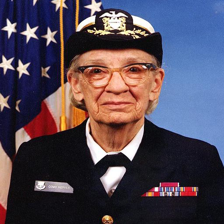

In [5]:
#Download image
grace_hopper = tf.keras.utils.get_file('image.jpg','https://storage.googleapis.com/download.tensorflow.org/example_images/grace_hopper.jpg')
grace_hopper = Image.open(grace_hopper).resize((IMAGE_RES, IMAGE_RES))
grace_hopper 

In [6]:
#Remember, models always want a batch of images to process. So here, we add a batch dimension, and pass the image to the model for prediction.
grace_hopper = np.array(grace_hopper)/255.0
grace_hopper.shape

(224, 224, 3)

In [7]:
#The result is a 1001 element vector of logits, rating the probability of each class for the image.
result = model.predict(grace_hopper[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(1, 1001)

In [8]:
predicted_class = np.argmax(result[0], axis=-1)
predicted_class
#So the top class ID can be found with argmax. But how can we know what class this actually is and in particular if that class ID in the ImageNet dataset denotes a military uniform or something else?

653

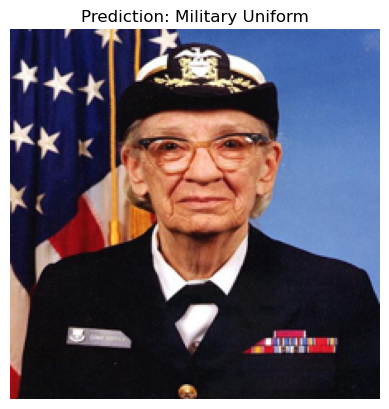

In [9]:
#download imagenet labels
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

#Show picture
plt.imshow(grace_hopper)
plt.axis('off')

#Show label name
predicted_class_name = imagenet_labels[predicted_class]
_ = plt.title("Prediction: " + predicted_class_name.title())

#### Part 2: Use a TensorFlow Hub models for the stanford_dogs dataset
Now we'll use the full MobileNet model and see how it can perform on the stanford_dogs dataset.

#### Load Dataset

In [10]:
!pip install tensorflow-datasets

In [62]:
(train_examples, validation_examples), info = tfds.load(
    'colorectal_histology',
    with_info=True, 
    as_supervised=True, 
    split=['train[:80%]', 'train[80%:]'],
    download=True
)

In [63]:
num_examples = info.splits['train'].num_examples
num_classes = info.features['label'].num_classes

In [51]:
num_classes

8

In [64]:
for i, example_image in enumerate(train_examples.take(3)):
  print("Image {} shape: {}".format(i+1, example_image[0].shape))

Image 1 shape: (150, 150, 3)
Image 2 shape: (150, 150, 3)
Image 3 shape: (150, 150, 3)


Resize images so they are all the same size.

In [67]:
def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches      = train_examples.shuffle(num_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_examples.map(format_image).batch(BATCH_SIZE).prefetch(1)

In [68]:
image_batch, label_batch = next(iter(train_batches.take(1)))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

result_batch = model.predict(image_batch)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


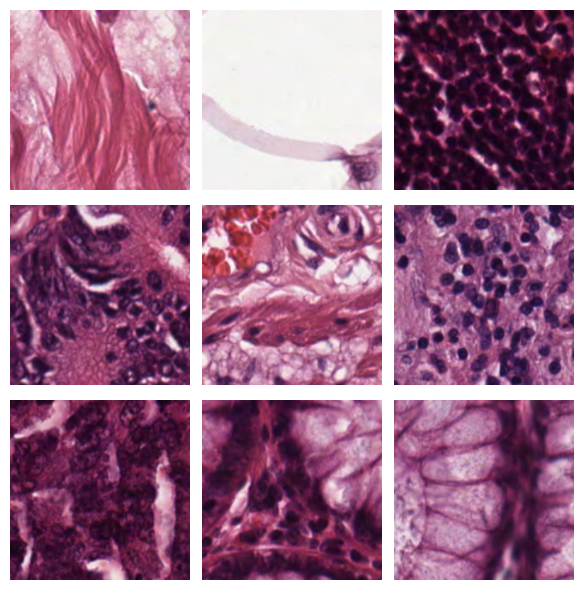

In [69]:
plt.figure(figsize=(6,6))
for n in range(9):
  plt.subplot(3,3,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  plt.axis('off')

plt.tight_layout()

#### Part 3: Do simple transfer learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning.

With transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

In addition to complete models, TensorFlow Hub also distributes models without the last classification layer. These can be used to easily do transfer learning. We will continue using MobileNet v2 because in later parts of this course, we will take this model and deploy it on a mobile device using TensorFlow Lite. Any image feature vector URL from tfhub.dev would work here.

We'll also continue to use the Dogs vs Cats dataset, so we will be able to compare the performance of this model against the ones we created from scratch earlier.

Note that we're calling the partial model from TensorFlow Hub (without the final classification layer) a feature_extractor. The reasoning for this term is that it will take the input all the way to a layer containing a number of features. So it has done the bulk of the work in identifying the content of an image, except for creating the final probability distribution. That is, it has extracted the features of the image.

In [70]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2"

model = tf.keras.Sequential()

# Wrap the KerasLayer in a Lambda layer
model.add(tf.keras.layers.Lambda(
    lambda x: hub.KerasLayer(URL)(x),
    input_shape=(IMAGE_RES, IMAGE_RES, 3)
))


Let's run a batch of images through this, and see the final shape. 32 is the number of images, and 1280 is the number of neurons in the last layer of the partial model from TensorFlow Hub.

In [71]:
feature_batch = model(image_batch)
print(feature_batch.shape)

(32, 1280)


In [72]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_5 (Lambda)               │ (None, 1280)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [73]:
model.trainable = False

In [74]:
model.add(tf.keras.layers.Dense(8)) #Add classification layer

In [75]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda_5 (Lambda)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 8)              │        10,248 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,248 (40.03 KB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 10,248 (40.03 KB)

#### Train the model
We now train this model like any other, by first calling compile followed by fit.

In [76]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

EPOCHS = 2
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/2


c:\Users\ih371\anaconda3\Lib\site-packages\keras\src\backend\tensorflow\trainer.py:74: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


125/125 ━━━━━━━━━━━━━━━━━━━━ 23s 142ms/step - accuracy: 0.1829 - loss: 7.9837 - val_accuracy: 0.1760 - val_loss: 7.7861
Epoch 2/2
125/125 ━━━━━━━━━━━━━━━━━━━━ 15s 124ms/step - accuracy: 0.1852 - loss: 7.8016 - val_accuracy: 0.1760 - val_loss: 7.7861


The MobileNet is unable to perform well as likely not trained on histological images of the colon. We will attempt to  use another trained model in a separate project.

In [78]:
class_names = np.array(info.features['label'].names)
class_names

array(['tumor', 'stroma', 'complex', 'lympho', 'debris', 'mucosa',
       'adipose', 'empty'], dtype='<U7')

In [79]:
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
predicted_class_names

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array(['mucosa', 'complex', 'tumor', 'tumor', 'tumor', 'mucosa', 'empty',
       'tumor', 'tumor', 'debris', 'empty', 'lympho', 'tumor', 'tumor',
       'tumor', 'tumor', 'tumor', 'stroma', 'lympho', 'tumor', 'mucosa',
       'complex', 'tumor', 'empty', 'stroma', 'debris', 'tumor', 'tumor',
       'tumor', 'lympho', 'lympho', 'stroma'], dtype='<U7')

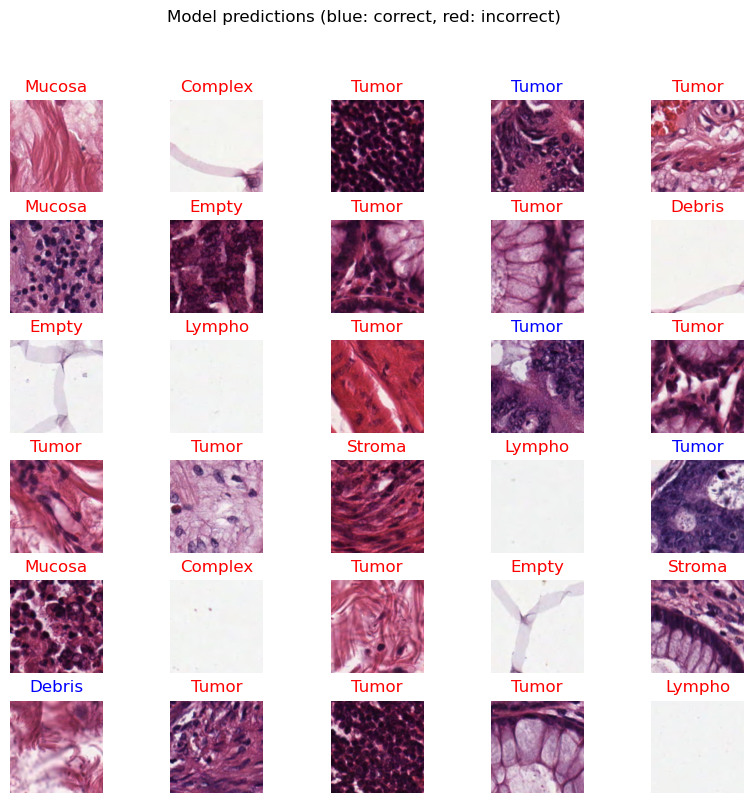

In [80]:
plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.subplots_adjust(hspace = 0.3)
  plt.imshow(image_batch[n])
  color = "blue" if predicted_ids[n] == label_batch[n] else "red"
  plt.title(predicted_class_names[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")